In [27]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire_r', 2)


%matplotlib inline
#Przetwarzanie

from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import KNNImputer
# Baza danych gównych do nauki modelu
train = pd.read_csv("train.csv") 
# Baza danych Titanica do sprawdzenia modelu
test = pd.read_csv("test.csv")

In [28]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [29]:
print(train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


# Czyszczenie i przygotowanie danych

In [30]:
print(pd.isnull(train).sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [31]:
print(pd.isnull(test).sum())

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


#### Przygotwanie kolumny 'Cabin' do encodowania

In [32]:
def extract_cabin_details(cabin):
  try:
    parts = cabin.split('/')
    if len(parts) == 2:
      cabin_type, deck_level = parts
      section_number = None
    elif len(parts) == 3:
      cabin_type, deck_level, section_number = parts
    else:
      raise ValueError("Nieprawidłowy format wartości w kolumnie Cabin")
    return cabin_type, int(deck_level), section_number
  except ValueError:
    return None, None, None

for df in [train, test]:
  df['Cabin_Filled'] = df['Cabin'].notna()

  # Ekstrakcja parametrów
  df.loc[df['Cabin_Filled'], 'Cabin_Type'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[0]
  df.loc[df['Cabin_Filled'], 'Cabin_Deck'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[1]
  df.loc[df['Cabin_Filled'], 'Cabin_Section'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[2]

  # Uzupełnianie wartości NaN
  df['Cabin_Type'].replace('NaN', np.nan, inplace=True)
  df['Cabin_Deck'].replace('NaN', np.nan, inplace=True)
  df['Cabin_Section'].replace('NaN', np.nan, inplace=True)

  # Konwersja typów
  df['Cabin_Deck'] = df['Cabin_Deck'].astype('float')
  df['Cabin_Type'] = df['Cabin_Type'].astype('category')
  df['Cabin_Section'] = df['Cabin_Section'].astype('category')

  # Usunięcie kolumny pomocniczej
  del df['Cabin_Filled']

#### Przygotwanie kolumny Name do zastępienia jej kolumną rodzina

In [33]:
for df in [train, test]:
  # Create Last_Name column, handling missing values
  df['Last_Name'] = df['Name'].str.split().str[-1].fillna(pd.NA)

In [34]:
def find_groups(df):
    groups = {}
    for name, group in df.groupby('Last_Name'):
        for cabin, subgroup in group.groupby('Cabin'):
            if len(subgroup) > 1:
                if subgroup['Family'].all():
                    subgroup['Family'] = 1
                groups[name] = list(subgroup.index)

    return groups

# Zastosowanie funkcji do DataFrame'ów test i train
for df in [test, train]:
    df['Family'] = 0
    groups = find_groups(df.copy())
    for name, group in groups.items():
        df.loc[group, 'Family'] = 1
train['Family'].value_counts()

Family
0    6513
1    2180
Name: count, dtype: int64

#### Ordinal encoding

In [35]:
enc = OrdinalEncoder()
Enc_col = ['HomePlanet', 'CryoSleep', 'Destination' , 'VIP', 'Cabin_Type', 'Cabin_Section' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: HomePlanet
  Wartość zakodowana: 0 -> Wartość początkowa: Earth
  Wartość zakodowana: 1 -> Wartość początkowa: Europa
  Wartość zakodowana: 2 -> Wartość początkowa: Mars
  Wartość zakodowana: 3 -> Wartość początkowa: nan
Kolumna: CryoSleep
  Wartość zakodowana: 0 -> Wartość początkowa: False
  Wartość zakodowana: 1 -> Wartość początkowa: True
  Wartość zakodowana: 2 -> Wartość początkowa: nan
Kolumna: Destination
  Wartość zakodowana: 0 -> Wartość początkowa: 55 Cancri e
  Wartość zakodowana: 1 -> Wartość początkowa: PSO J318.5-22
  Wartość zakodowana: 2 -> Wartość początkowa: TRAPPIST-1e
  Wartość zakodowana: 3 -> Wartość początkowa: nan
Kolumna: VIP
  Wartość zakodowana: 0 -> Wartość początkowa: False
  Wartość zakodowana: 1 -> Wartość początkowa: True
  Wartość zakodowana: 2 -> Wartość początkowa: nan
Kolumna: Cabin_Type
  Wartość zakodowana: 0 -> Wartość początkowa: A
  Wartość zakodowana: 1 -> Wartość początkowa: B
  Wartość zakodowana: 2 -> Wartość początkowa: C
  Wartoś

In [36]:
categorical_features = ['PassengerId','HomePlanet', 'CryoSleep', 'Cabin', 'Destination' , 'Name', 'VIP', 'Cabin_Type', 'Last_Name',  'Cabin_Section']
for df in [train, test]:
     df.drop(columns=categorical_features, inplace=True)
print(pd.isnull(train).sum())

Age                  179
RoomService          181
FoodCourt            183
ShoppingMall         208
Spa                  183
VRDeck               188
Transported            0
Cabin_Deck           199
Family                 0
HomePlanet_Enc       201
CryoSleep_Enc        217
Destination_Enc      182
VIP_Enc              203
Cabin_Type_Enc       199
Cabin_Section_Enc    199
dtype: int64


In [37]:
train.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Cabin_Deck', 'Family', 'HomePlanet_Enc',
       'CryoSleep_Enc', 'Destination_Enc', 'VIP_Enc', 'Cabin_Type_Enc',
       'Cabin_Section_Enc'],
      dtype='object')

#### Uzupełnianie brakujących wartości

In [38]:
def fill_missing_values(df):
  # Create KNN Imputer with 5 neighbors
  imputer = KNNImputer(n_neighbors=5)
  # Identify columns with missing values
  cols_with_missing = [col for col in df.columns if df[col].isna().any()]
  # Impute values
  df_imputed = imputer.fit_transform(df)
  # Assign all imputed columns back to the DataFrame
  df[:] = df_imputed
  return df

for df in [train, test]:
  df = fill_missing_values(df)


#### Modele standaryzujące

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
# Wybór kolumn do standaryzacji
kolumny = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Tworzenie obiektu StandardScaler
scaler = RobustScaler()

# Dopasowanie i transformacja danych treningowych
scaler.fit(train[kolumny])
train_scaled = scaler.transform(train[kolumny])

# Transformacja danych testowych
test_scaled = scaler.transform(test[kolumny])

# Dodanie przetworzonych kolumn do data frame
for df in [train, test]:
  df[kolumny] = scaler.transform(df[kolumny])

In [40]:
from sklearn.preprocessing import PolynomialFeatures
kolumny = ['RoomService', 'VRDeck']

# Create PolynomialFeatures object (without n_output_features_)
poly = PolynomialFeatures(degree=2, interaction_only=True)

# Transform data
for df in [train, test]:
    df = poly.fit_transform(df[kolumny])
train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Family,HomePlanet_Enc,CryoSleep_Enc,Destination_Enc,VIP_Enc,Cabin_Type_Enc,Cabin_Section_Enc,,VRDeck_VRDeck,RoomService_RoomService
0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0,1.0,0.0,2.0,0.0,1.0,0.0,0.000000,0.000000,0.000000
1,24.0,2.096154,0.113924,0.862069,18.266484,8.714286,1.0,0.0,0,0.0,0.0,2.0,0.0,5.0,1.0,0.846154,1.773669,7.373626
2,58.0,0.826923,45.265823,0.000000,88.139499,106.587302,0.0,0.0,0,1.0,0.0,2.0,1.0,0.0,1.0,0.942308,0.779216,100.438034
3,33.0,0.000000,16.240506,12.793103,0.000000,52.841270,0.0,0.0,0,1.0,0.0,2.0,0.0,0.0,1.0,3.711538,0.000000,196.122405
4,16.0,5.826923,0.886076,5.206897,52.257326,8.968254,1.0,1.0,0,0.0,0.0,2.0,0.0,5.0,1.0,0.038462,0.224112,0.344933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.000000,86.316456,0.000000,0.000000,26.079365,0.0,98.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.423077,0.000000,37.112943
8689,18.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1499.0,0,0.0,1.0,1.0,0.0,6.0,1.0,0.000000,0.000000,0.000000
8690,26.0,0.000000,0.000000,64.551724,0.000000,0.015873,1.0,1500.0,0,0.0,0.0,2.0,0.0,6.0,1.0,0.000000,0.000000,0.000000
8691,32.0,0.000000,13.278481,0.000000,0.000000,5.603175,0.0,608.0,1,1.0,0.0,0.0,0.0,4.0,1.0,62.211538,0.000000,348.582112


## Wizualizacja

Text(0.5, 1.05, 'Macierz korelacji Perasona')

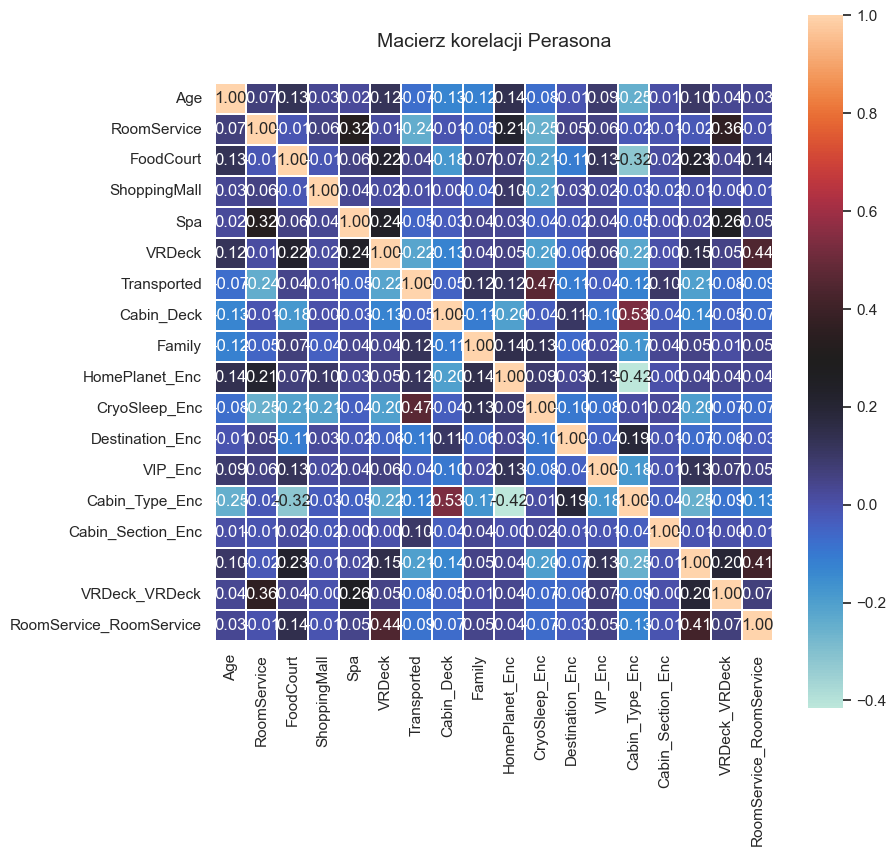

In [41]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Macierz korelacji Perasona', y=1.05,   size=14)

In [42]:
train.groupby('Transported').mean().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Family,HomePlanet_Enc,CryoSleep_Enc,Destination_Enc,VIP_Enc,Cabin_Type_Enc,Cabin_Section_Enc,,VRDeck_VRDeck,RoomService_RoomService
Transported,,,,,,,,,,,,,,,,,
0.0,29.87,7.41,4.83,5.78,44.67,8.85,625.01,0.2,0.57,0.14,1.57,0.03,4.52,0.45,10.33,36.70,168.34
1.0,27.75,1.24,6.63,6.09,3.00,0.99,576.58,0.3,0.76,0.59,1.39,0.02,4.10,0.56,1.36,2.76,5.96


## Modele Predykcyjne

In [43]:
#Biblioteki
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics         import make_scorer, f1_score, accuracy_score

from sklearn.neural_network  import MLPClassifier

from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import HistGradientBoostingClassifier

from sklearn.naive_bayes     import GaussianNB

from sklearn.svm             import NuSVC

from sklearn.neighbors       import KNeighborsClassifier

from catboost                import CatBoostClassifier

In [44]:
#Baza danych
X_train = train.drop('Transported',axis=1)
y_train = train['Transported']

X_test = test
y_test = []

testt = pd.read_csv("test.csv")
submission_df1 = pd.DataFrame({"PassengerId": testt['PassengerId']})



In [45]:
#Modele które zostaną wykorzystane
classifiers = [['Random Forest',RandomForestClassifier()],
               ['AdaBoost',AdaBoostClassifier()],
               ['Gradient Boosting',GradientBoostingClassifier()],
               ['Nu Support Vector Machine', NuSVC()], 
               ['HGBC',HistGradientBoostingClassifier()], 
               ['Naive Bayes',GaussianNB()],
               ['Cat', CatBoostClassifier(verbose=False)],
              ]

In [46]:
## Wstępna ocena wydajności modeli z domyślnymi parametrami
import warnings
warnings.simplefilter('ignore')

for metric in ['accuracy','f1']:
    SKfold = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
    score_mean = []
    std = []
    
    for model in classifiers:
        clf = model[1]
        cv_result = cross_val_score(clf,X_train, y_train, cv = SKfold, scoring = metric, n_jobs=-1)
        cv_result = cv_result
        score_mean.append(cv_result.mean())
        std.append(cv_result.std())
        
    models_evaluation = pd.DataFrame({metric: score_mean}, index=[i[0] for i in classifiers])
    print(models_evaluation.sort_values(metric, ascending=False))
    print('*'*32)

                           accuracy
Cat                        0.811067
HGBC                       0.807938
Gradient Boosting          0.804256
Random Forest              0.798803
AdaBoost                   0.792593
Nu Support Vector Machine  0.780789
Naive Bayes                0.626803
********************************
                                 f1
Cat                        0.811179
Gradient Boosting          0.810151
HGBC                       0.808670
Nu Support Vector Machine  0.801248
AdaBoost                   0.799877
Random Forest              0.793982
Naive Bayes                0.722974
********************************


In [47]:
from sklearn.metrics import accuracy_score, f1_score, make_scorer

# param_grids = {
#     'Random Forest': {
#         'n_estimators': [100, 125, 150, 175, 200, 225, 250, 300],
#         'max_depth': [5, 6, 7, 8, 9, 10 ,11, 12]
#     },
#     'AdaBoost': {
#         'n_estimators': [140, 160, 175, 195, 205, 225, 245],
#         'learning_rate': [0.75, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]
#     },
#     'Gradient Boosting': {
#         'n_estimators': [75, 100, 125, 150, 175, 200, 225, 250],
#         'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
#     },
#     'Nu Support Vector Machine': {
#         'nu': [0.4, 0.5, 0.6],
#         'kernel': ['linear', 'rbf']
#     },
#     'HGBC': {
#         'learning_rate': [0.0025, 0.05, 0.0075, 0.1, 0.25, 0.5]
#     }
# }

# # Perform GridSearchCV for each classifier with accuracy evaluation
# for name, clf in classifiers:
#     param_grid = param_grids[name]
#     scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
#     grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=SKfold, scoring=scoring, refit='accuracy', n_jobs=-1)
  
#     grid_search.fit(X_train, y_train)

#     # Print the best model's accuracy and parameters
#     best_model = grid_search.best_estimator_
#     best_score = grid_search.best_score_
#     best_params = grid_search.best_params_

#     print(f"\n{name} Model:")
#     print(f"Best Accuracy on Training Data: {best_score:.4f}")
#     print(f"Best Parameters: {best_params}")

#### Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score  
warnings.simplefilter('ignore')

estimators = [
    ('Random Forest', RandomForestClassifier(n_estimators=250, max_depth = 12)),
    ('Ada Boost', AdaBoostClassifier(learning_rate=0.75,n_estimators = 145)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1 )),
    ('Cat', CatBoostClassifier(verbose=False)),
    ('HGBC', HistGradientBoostingClassifier(learning_rate=0.05)),
    ('NuSVC',NuSVC()),
     ]

# Final estimator
final_estimator = LogisticRegressionCV()
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

# Perform cross-validation for each model and the StackingClassifier
for name, model in classifiers:
    scores = cross_val_score(model, X_train, y_train, cv=SKfold, scoring='accuracy', n_jobs=-1)
    print(f"{name}: {scores.mean():.3f} (+/- {scores.std():.3f})")
clf.fit(X_train,y_train) 

scores = cross_val_score(clf, X_train, y_train, cv=SKfold, scoring='accuracy', n_jobs=-1)
print(f"Stacking Classifier: {scores.mean():.3f} (+/- {scores.std():.3f})")

y_pred = clf.predict(X_test)


submission_df1['Transported'] = y_pred.astype('bool')
submission_df1 = submission_df1[['PassengerId', 'Transported']]
submission_df1.to_csv('submission1.csv', index=False)

Random Forest: 0.800 (+/- 0.006)
AdaBoost: 0.793 (+/- 0.007)
Gradient Boosting: 0.805 (+/- 0.008)
Nu Support Vector Machine: 0.780 (+/- 0.009)
HGBC: 0.809 (+/- 0.007)
Naive Bayes: 0.627 (+/- 0.005)
Cat: 0.811 (+/- 0.007)


# Ula lala
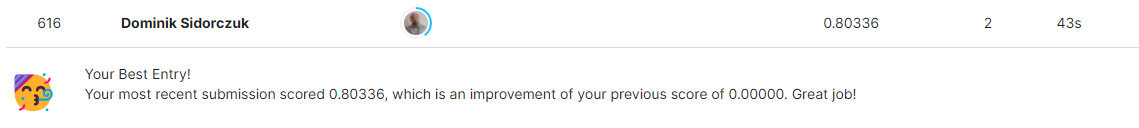